# Homework 5


In [0]:
!pip install tensorflow-gpu

In [0]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [0]:
!pip install kaggle

In [0]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from glob import glob

In [0]:
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import (
    Dense, 
    Activation, 
    Dropout, 
    BatchNormalization, 
    Input, 
    Add,
    Conv2D,
    MaxPooling2D,
    Flatten
)

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

### Task 1

Run a multilayer perceptron (feed forward neural network) with two hidden layers and rectified linear nonlinearities on the iris dataset using the keras​ Sequential interface​. Include code for selecting regularization strength and number of hidden units using GridSearchCV and evaluation on an independent test-set.


In [0]:
iris = datasets.load_iris()
iris.data.shape

(150, 4)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=0)

In [0]:
num_classes = len(iris.target_names)

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def make_model(optimizer='adam', hidden_size=32, alpha=0.1):
  
    model = Sequential([
        Dense(
            hidden_size, 
            kernel_regularizer=regularizers.l2(alpha),
            input_shape=(iris.data.shape[1], )),
        Activation('relu'),
        Dense(num_classes),
        Activation('softmax')
    ])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [0]:
make_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


Below I set up a parameter grid for selecting regularization strength and number of hidden units within GridSearchCV:

In [0]:
clf = KerasClassifier(make_model)

param_grid = {
    'epochs': [30], # we weren't asked to grid search epochs so only 1 value for convenience 
    'alpha': [0.1, 0.001, 0.0001], # regularization strength
    'hidden_size': [32, 64, 256], # number of hidden units
}
 
# For this task at least, cv=5 didn't take that long re Piazza @590
grid = GridSearchCV(clf, param_grid=param_grid, cv=StratifiedShuffleSplit(n_splits=3, random_state=42), return_train_score=True)
grid.fit(X_train, y_train)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 1s 15ms/step - loss: 2.0401 - acc: 0.6600
Epoch 2/30
100/100 [==============================] - 0s 152us/step - loss: 1.9369 - acc: 0.6600
Epoch 3/30
100/100 [==============================] - 0s 144us/step - loss: 1.8422 - acc: 0.6700
Epoch 4/30
100/100 [==============================] - 0s 162us/step - loss: 1.7547 - acc: 0.6700
Epoch 5/30
100/100 [==============================] - 0s 139us/step - loss: 1.6782 - acc: 0.6700
Epoch 6/30
100/100 [==============================] - 0s 172us/step - loss: 1.6140 - acc: 0.6700
Epoch 7/30
100/100 [==============================] - 0s 172us/step - loss: 1.5587 - acc: 0.6700
Epoch 8/30
100/100 [==============================] - 0s 175us/step - loss: 1.5123 - acc: 0.6700
Epoch 9/30
100/100 [==============================] - 0s 163us/step - loss: 1.4794 - acc: 0.6700
Epoch 10/30
100/100 [==============================] - 0s 161us/step - loss: 1.4

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size='default',
            train_size=None),
       error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7923cffc50>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'epochs': [30], 'alpha': [0.1, 0.001, 0.0001], 'hidden_size': [32, 64, 256]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=['param_epochs', 'param_alpha', 'param_hidden_size'],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_alpha param_hidden_size                                   
30           0.0001      32                        0.750000          0.790000
                         64                        0.722222          0.780000
                         256                       0.833333          0.903333
             0.0010      32                        0.750000          0.806667
                         64                        0.694444          0.750000
                         256                       0.861111          0.890000
             0.1000      32                        0.722222          0.780000
                         64                        0.750000          0.743333
                         256                       0.861111          0.870000

In [0]:
grid.score(X_train, y_train)

112/112 [==============================] - 1s 6ms/step


0.9642857142857143

In [0]:
grid.score(X_test, y_test)

38/38 [==============================] - 0s 408us/step


1.0

In [0]:
grid.best_params_

{'alpha': 0.1, 'epochs': 30, 'hidden_size': 256}

Given that the dataset is not too large, since the model trained quite well (~96% training accuracy) this was actually a good enough model to correctly classify all elements in the test set as we have a test score of 100%.  Also printed are the best parameters found via grid search. 

### Task 2

Train a multilayer perceptron (fully connected) on the Fashion MNIST dataset using the traditional train/test split as given by fashion_mnist.load_data in keras. Use a separate 10000 samples (from the training set) for model selection and to compute learning curves (accuracy vs epochs, not vs n_samples). Compare a “vanilla” model with a model using drop-out (potentially a bigger model), and to a model using batch normalization and residual connections (but not dropout). Visualize learning curves for all models.

#### Data 
First I load the data and check out some of the actual images from our dataset:

In [0]:
((X_train2, y_train2), (X_test2, y_test2)) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
print("X_train2 shape:", X_train2.shape, "y_train2 shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape, "y_test2 shape:", y_test2.shape)

X_train2 shape: (60000, 28, 28) y_train2 shape: (60000,)
X_test2 shape: (10000, 28, 28) y_test2 shape: (10000,)


In [0]:
# this function is used in Task 3 as well
def show_image(X, y, labels, seed=None):
  """ 
  This will show a new image from dataset each time the it is run and its label
    X - ndarray, x data
    y - ndarray, target
    labels - dict, y labels
  """
  # Optionally set seed
  np.random.seed(seed=seed)
  
  # Random index
  rand_idx = np.random.randint(0, high=y.shape[0])

  # Get the label key to lookup label
  label_key = y[rand_idx]

  # Print the label for the index
  print(f'Label for Index {rand_idx:,}: ', labels[label_key])

  # Show the image for the index
  plt.imshow(X[rand_idx])
  plt.show()

Label for Index 4,462:  Pullover


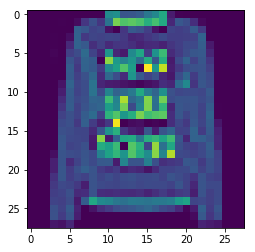

Label for Index 35,175:  Trouser


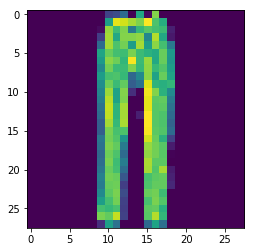

Label for Index 17,855:  Coat


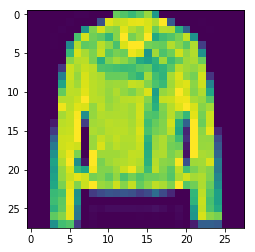

In [0]:
# Fashion MNIST Label Descriptions
fashion_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

for i in range(3):
  show_image(X_train2, y_train2, fashion_labels)

Next I reshape and normalize the data:

In [0]:
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1] * X_train2.shape[2])
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1] * X_test2.shape[2])

X_train2 = X_train2.astype('float32') / 255
X_test2 = X_test2.astype('float32') / 255

And split the training set again to get a validation set of 10k samples for model selection (via trial and error as per Piazza @610):

In [0]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=10000, stratify=y_train2, random_state=0)

Like in Task 1, I one hot encode the target classes:

In [0]:
# convert class vectors to binary class matrices
y_train2 = keras.utils.to_categorical(y_train2, len(fashion_labels))
y_val2 = keras.utils.to_categorical(y_val2, len(fashion_labels))
y_test2 = keras.utils.to_categorical(y_test2, len(fashion_labels))


In [0]:
print("X_train2 shape:", X_train2.shape, "y_train2 shape:", y_train2.shape)
print("X_val2 shape:", X_val2.shape, "y_val2 shape:", y_val2.shape)
print("X_test2 shape:", X_test2.shape, "y_test2 shape:", y_test2.shape)

X_train2 shape: (50000, 784) y_train2 shape: (50000, 10)
X_val2 shape: (10000, 784) y_val2 shape: (10000, 10)
X_test2 shape: (10000, 784) y_test2 shape: (10000, 10)


#### Model (a): Vanilla

In [0]:
model2a = Sequential([
    Dense(1024, input_shape=(X_train2.shape[1], )),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(256),
    Activation('relu'),
    Dense(128),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(len(fashion_labels)),
    Activation('softmax')
])

model2a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 1024)              803840    
_________________________________________________________________
activation_101 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 512)               524800    
_________________________________________________________________
activation_102 (Activation)  (None, 512)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_103 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 128)               32896     
__________

#### Model (b): Dropout

In [0]:
model2b = Sequential([
    Dense(1024, input_shape=(X_train2.shape[1], )),
    Activation('relu'),
    Dropout(rate=.5),
    Dense(512),
    Activation('relu'),
    Dropout(rate=.4),
    Dense(256),
    Activation('relu'),
    Dropout(rate=.3),
    Dense(128),
    Activation('relu'),
    Dropout(rate=.2),
    Dense(64),
    Activation('relu'),
    Dropout(rate=.1),
    Dense(32),
    Activation('relu'),
    Dropout(rate=.05),
    Dense(len(fashion_labels)),
    Activation('softmax')
])

model2b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model2b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 1024)              803840    
_________________________________________________________________
activation_108 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 512)               524800    
_________________________________________________________________
activation_109 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 256)               131328    
__________

#### Model (c): Batch Normalization & ResNet


In [0]:
# Functional Graph
inputs = Input(shape=(X_train2.shape[1],))
x1 = Dense(1024)(inputs)
b1 = BatchNormalization()(x1)
a1 = Activation('relu')(b1)
x2 = Dense(1024)(a1)
b2 = BatchNormalization()(x2)
a2 = Activation('relu')(b2)
r1 = Add()([a1, a2])

x3 = Dense(512)(r1)
b3 = BatchNormalization()(x3)
a3 = Activation('relu')(b3)
x4 = Dense(512, activation='relu')(a3)
b4 = BatchNormalization()(x4)
a4 = Activation('relu')(b4)
r2 = Add()([a3, a4])

predictions = Dense(len(fashion_labels), activation='softmax')(r2)
model2c = Model(inputs=inputs, outputs=predictions)
model2c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model2c.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_173 (Dense)               (None, 1024)         803840      input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 1024)         4096        dense_173[0][0]                  
__________________________________________________________________________________________________
activation_151 (Activation)     (None, 1024)         0           batch_normalization_79[0][0]     
__________________________________________________________________________________________________
dense_174 

#### Training

First I create a function for computing learning curves, both for training and validation accuracy vs epoch for an arbitrary dict of trained models:

In [0]:
# this function is used in Task 3 as well
def learning_curves(models, x_field='epoch', y_field='acc', title='Learning Curves', **kwargs):
  """ 
    plots learning curve for multiple models
    
    models: a dict containing trained models keyed to model names 
    x_field: a string, must be a key in model.history.__dict__ for accessing x axis data
    y_field: a string, must be a key in model.history.history for accessing y axis data
    
    note we plot the training and validation score, so y_field must must be a key in model.history.history 
    but "val_y_field" must also be a key in model.history.history
  """

  plt.figure(**kwargs)
    
  for name, model in models.items():
    plt.plot(model.history.__dict__[x_field], model.history.history[y_field], label=f'{name} Train')
    plt.plot(model.history.__dict__[x_field], model.history.history[f'val_{y_field}'], label=f'{name} Val')


  plt.xlabel(x_field)
  plt.ylabel(y_field)
  plt.title(title)
  plt.legend()
  plt.show()

In [0]:
model2a.fit(X_train2, y_train2, batch_size=5000, epochs=50, validation_data=(X_val2, y_val2), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.5727 - acc: 0.4816 - val_loss: 0.8582 - val_acc: 0.6740
Epoch 2/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.8173 - acc: 0.7033 - val_loss: 0.6616 - val_acc: 0.7637
Epoch 3/50
50000/50000 [==============================] - 0s 6us/step - loss: 0.6075 - acc: 0.7905 - val_loss: 0.5471 - val_acc: 0.8051
Epoch 4/50
50000/50000 [==============================] - 0s 6us/step - loss: 0.5194 - acc: 0.8185 - val_loss: 0.5301 - val_acc: 0.8056
Epoch 5/50
50000/50000 [==============================] - 0s 6us/step - loss: 0.4790 - acc: 0.8310 - val_loss: 0.4724 - val_acc: 0.8247
Epoch 6/50
50000/50000 [==============================] - 0s 6us/step - loss: 0.4371 - acc: 0.8475 - val_loss: 0.4267 - val_acc: 0.8458
Epoch 7/50
50000/50000 [==============================] - 0s 6us/step - loss: 0.4077 - acc: 0.8577 - val_loss: 0.4089 - val_acc: 0.8

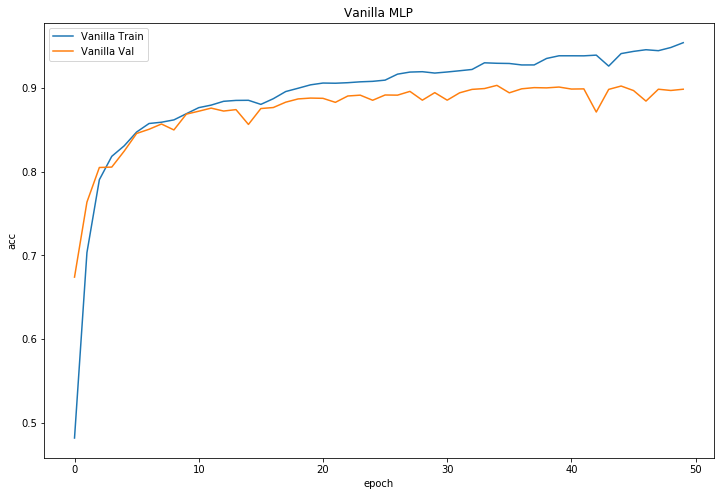

In [0]:
learning_curves({'Vanilla': model2a}, **{'figsize': (12,8)}, title='Vanilla MLP')

In [0]:
model2b.fit(X_train2, y_train2, batch_size=5000, epochs=50, validation_data=(X_val2, y_val2), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.8919 - acc: 0.3046 - val_loss: 1.1234 - val_acc: 0.5681
Epoch 2/50
50000/50000 [==============================] - 0s 7us/step - loss: 1.1890 - acc: 0.5591 - val_loss: 0.7940 - val_acc: 0.7087
Epoch 3/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.8894 - acc: 0.6798 - val_loss: 0.6505 - val_acc: 0.7588
Epoch 4/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.7249 - acc: 0.7435 - val_loss: 0.5517 - val_acc: 0.7946
Epoch 5/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.6230 - acc: 0.7817 - val_loss: 0.4896 - val_acc: 0.8237
Epoch 6/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.5627 - acc: 0.8064 - val_loss: 0.4498 - val_acc: 0.8399
Epoch 7/50
50000/50000 [==============================] - 0s 7us/step - loss: 0.5132 - acc: 0.8227 - val_loss: 0.4242 - val_acc: 0.8

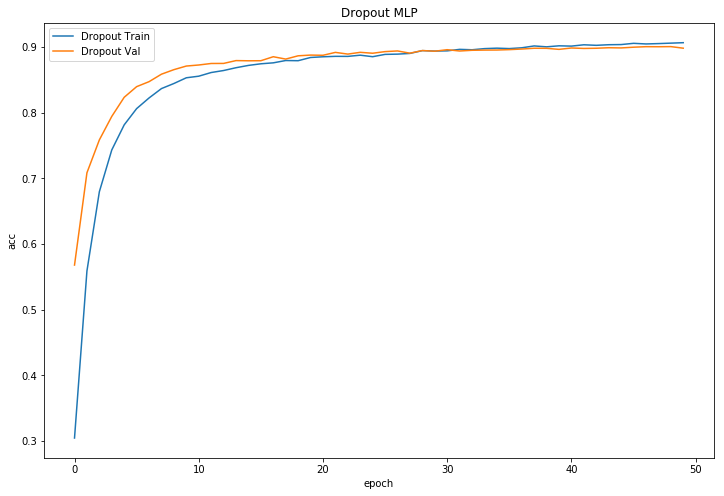

In [0]:
learning_curves({'Dropout': model2b}, **{'figsize': (12,8)}, title='Dropout MLP')

In [0]:
model2c.fit(X_train2, y_train2, batch_size=5000, epochs=50, validation_data=(X_val2, y_val2), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.9670 - acc: 0.7221 - val_loss: 0.7883 - val_acc: 0.7459
Epoch 2/50
50000/50000 [==============================] - 0s 10us/step - loss: 0.3858 - acc: 0.8609 - val_loss: 0.6074 - val_acc: 0.7942
Epoch 3/50
50000/50000 [==============================] - 0s 10us/step - loss: 0.3178 - acc: 0.8847 - val_loss: 0.4703 - val_acc: 0.8230
Epoch 4/50
50000/50000 [==============================] - 0s 10us/step - loss: 0.2759 - acc: 0.8981 - val_loss: 0.3619 - val_acc: 0.8659
Epoch 5/50
50000/50000 [==============================] - 0s 10us/step - loss: 0.2426 - acc: 0.9098 - val_loss: 0.3441 - val_acc: 0.8720
Epoch 6/50
50000/50000 [==============================] - 0s 10us/step - loss: 0.2101 - acc: 0.9235 - val_loss: 0.3220 - val_acc: 0.8859
Epoch 7/50
50000/50000 [==============================] - 1s 10us/step - loss: 0.1819 - acc: 0.9351 - val_loss: 0.3270 - val_a

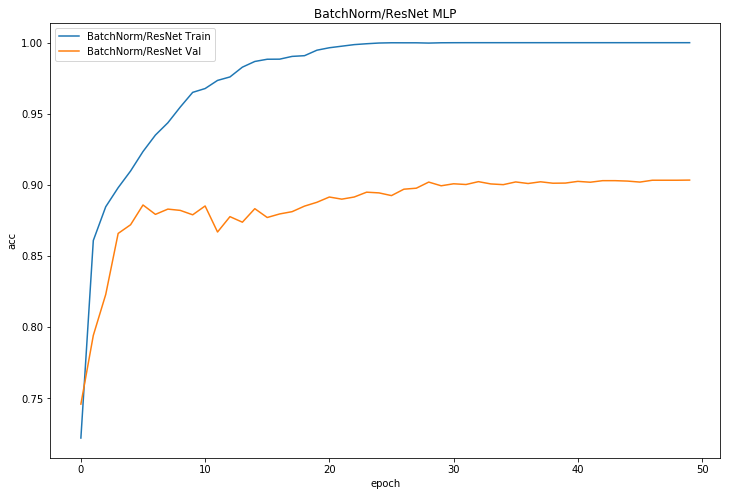

In [0]:
learning_curves({'BatchNorm/ResNet': model2c}, **{'figsize': (12,8)}, title='BatchNorm/ResNet MLP')

#### Validation Scores & Parameter Tuning

In [0]:
# trial and error
score2a = model2a.evaluate(X_val2, y_val2, verbose=0)
print(f"""Vanilla Validation Loss: {score2a[0]:.3f}""")
print(f"""Vanilla Validation Accuracy: {score2a[1]:.3f}""")

Vanilla Validation Loss: 0.321
Vanilla Validation Accuracy: 0.899


In [0]:
score2b = model2b.evaluate(X_val2, y_val2, verbose=0)
print(f"""Dropout Validation Loss: {score2b[0]:.3f}""")
print(f"""Dropout Validation Accuracy: {score2b[1]:.3f}""")

Dropout Validation Loss: 0.286
Dropout Validation Accuracy: 0.898


In [0]:
score2c = model2c.evaluate(X_val2, y_val2, verbose=0)
print(f"""BatchNorm/ResNet Validation Loss: {score2c[0]:.3f}""")
print(f"""BatchNorm/ResNet Validation Accuracy: {score2c[1]:.3f}""")

BatchNorm/ResNet Validation Loss: 0.437
BatchNorm/ResNet Validation Accuracy: 0.903


When I initially ran the models, I mimicked the feed forward model from Task 1, which included regularization.  However, through trial and error I found that removing the regularization significantly improved the validation score of each model (on the order of ~10% accuracy better).  Otherwise, I found that increasing the number of hidden layers improved the model, but the improvement leveled out after say 4-5 levels.  I also found increasing the number of hidden units per layer (relative to Task 1) improved the models by maybe a percent or two.  Increasing epochs also helped improve accuracy quite a bit.

I tried to keep the tuned parameters somewhat similar between the three models in order to get a sense of whether Dropout, or Batch Normalization and Residual Connections themselves improved the validation score.  While these latter two models saw slight improvement, the scores for all three models were very similar.

One thing to note also is that the ResNet model apparently trained much faster than the other models.  While it was the best of the three models by just a bit, it actually performed worse when I added additional layers to the model.

#### Learning Curves - Training and Validation

Now I plot learning curves (accuracy v/s epoch) for each of the three models together:

In [0]:
models = {
    'Vanilla': model2a,
    'Dropout': model2b,
    'BatchNorm/ResNet': model2c
}

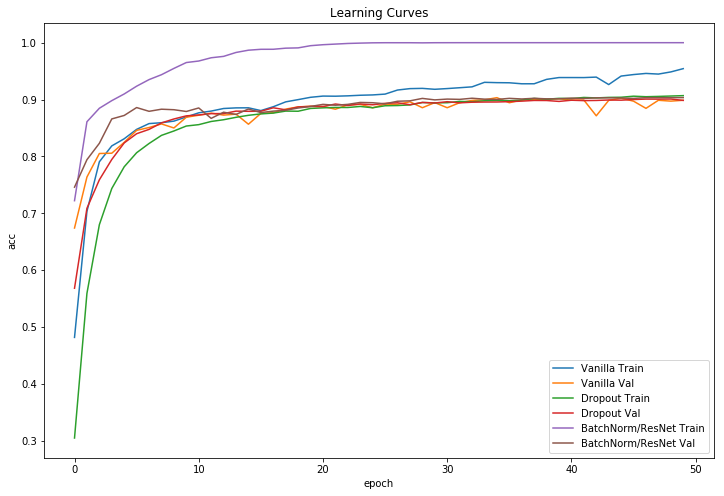

In [0]:
learning_curves(models, **{'figsize': (12,8)})

#### Generalization

Finally let's see how each of the models generalize to the test set:

In [0]:
# trial and error
gen2a = model2a.evaluate(X_test2, y_test2, verbose=0)
print(f"""Test Loss: {gen2a[0]:.3f}""")
print(f"""Test Accuracy: {gen2a[1]:.3f}""")

Test Loss: 0.377
Test Accuracy: 0.888


In [0]:
# trial and error
gen2b = model2b.evaluate(X_test2, y_test2, verbose=0)
print(f"""Test Loss: {gen2b[0]:.3f}""")
print(f"""Test Accuracy: {gen2b[1]:.3f}""")

Test Loss: 0.318
Test Accuracy: 0.889


In [0]:
# trial and error
gen2b = model2b.evaluate(X_test2, y_test2, verbose=0)
print(f"""Test Loss: {gen2b[0]:.3f}""")
print(f"""Test Accuracy: {gen2b[1]:.3f}""")

Test Loss: 0.318
Test Accuracy: 0.889


The latter two models, Dropout and Batch Norm/ResNet perform slightly better than the Vanilla model on the final test set, but the improvement is so minimal that it is really immaterial.

### Task 3

Train a convolutional neural network on the following dataset:
https://www.kaggle.com/paultimothymooney/breast-histopathology-images

#### Set up Kaggle API

In [0]:
# references: https://github.com/Kaggle/kaggle-api#api-credentials
# https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

# The path /root/.kaggle should exist by default I think — if not run 
!mkdir /root/.kaggle
os.chdir('/root/.kaggle')
file = files.upload() # upload kaggle.json
os.chdir('/content')

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (2).json


In [0]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v /content # configure where files are downloaded

- path is now set to: /content


#### Download Data

In [0]:
path = 'datasets/paultimothymooney/breast-histopathology-images'

In [0]:
!kaggle datasets download paultimothymooney/breast-histopathology-images

os.chdir(f'/content/{path}/')
!unzip -n breast-histopathology-images.zip

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  breast-histopathology-images.zip


In [0]:
# this takes a while to unzip all the image data
!unzip -n IDC_regular_ps50_idx5.zip # -n never overwrite
os.chdir('/content')

Archive:  IDC_regular_ps50_idx5.zip


#### Build Dataset

In [0]:
def build_dataset(path, clss):
  """ 
  loads and preps images, returns dataset
  param path is where to load data from
  param clss should be either 0 or 1 
  
  reference: https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images
  """
  x = []
  y = []
  WIDTH = 50
  HEIGHT = 50
  
  img_patches = glob(f'./{path}/**/{clss}/*.png', recursive=True)

  for img in img_patches:
    full_size_image = cv2.imread(img)
    x.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
    y.append(clss)
  
  return np.stack(x), np.stack(y)

In [0]:
X_0, y_0 = build_dataset(path, 0)

In [0]:
X_0.shape, y_0.shape

((198738, 50, 50, 3), (198738,))

In [0]:
X_1, y_1 = build_dataset(path, 1)

In [0]:
X_1.shape, y_1.shape

((78786, 50, 50, 3), (78786,))

I handle class imbalance by subsampling the data.  I ran the models with various dataset sample sizes but chose to use a relatively small sample, 40k total, compared with the full dataset because the models took quite long to run / and rerun. Using a smaller sample allowed me to experiment and iterate more quickly while working on model selection:

In [0]:
n = 20000 # 20k for each class, 40k total
X = np.concatenate([X_0[:n], X_1[:n]], axis=0)
y = np.concatenate([y_0[:n], y_1[:n]], axis=0)

Let's view some of the images for a sanity check

Label for Index 13,918:  IDC(-)


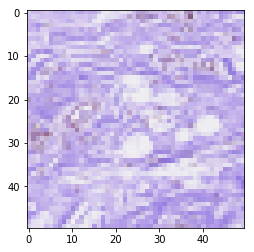

Label for Index 26,342:  IDC(+)


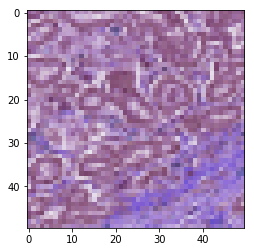

Label for Index 559:  IDC(-)


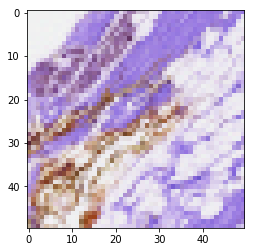

In [0]:
IDC_labels = {0: 'IDC(-)', 1: 'IDC(+)'} # Invasive Ductal Carcinoma (IDC) 

for i in range(3):
  show_image(X, y, IDC_labels)

Now train test split to get a test set of 5k:

In [0]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=5000, stratify=y, random_state=42)

Then, like in Task 1 and 2, I split the training set again into a validation set of 5k


In [0]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=5000, stratify=y_train3, random_state=42)

Also like in Task 1 and 2, I one hot encode the target classes:

In [0]:
y_train3 = keras.utils.to_categorical(y_train3, len(IDC_labels))
y_val3 = keras.utils.to_categorical(y_val3, len(IDC_labels))
y_test3 = keras.utils.to_categorical(y_test3, len(IDC_labels))

In [0]:
print("X_train3 shape:", X_train3.shape, "y_train3 shape:", y_train3.shape)
print("X_val3 shape:", X_val3.shape, "y_val3 shape:", y_val3.shape)
print("X_test3 shape:", X_test3.shape, "y_test3 shape:", y_test3.shape)

X_train3 shape: (30000, 50, 50, 3) y_train3 shape: (30000, 2)
X_val3 shape: (5000, 50, 50, 3) y_val3 shape: (5000, 2)
X_test3 shape: (5000, 50, 50, 3) y_test3 shape: (5000, 2)


#### 3.1 Vanilla CNN
Start with a model without residual connections (using batch normalization is likely to be helpful and you should try it, whether you use dropout is your choice).

In [0]:
cnn1 = Sequential()

cnn1.add(Conv2D(32, kernel_size=(3, 3), input_shape=X_train3[0].shape))
cnn1.add(BatchNormalization())
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(rate=.5))

cnn1.add(Conv2D(64, kernel_size=(3, 3), input_shape=X_train3[0].shape))
cnn1.add(BatchNormalization())
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(len(IDC_labels), activation='softmax'))


cnn1.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])

In [0]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 22, 22, 64)        256       
__________

**Note** While this model for 3.1 did not take too long to run, the models for 3.2 and 3.3 took much longer to train and required more RAM (which was limited in Google Colab), so I limited the epochs to ~20 so that I could experiment at a reasonable pace for model selection (I experimented with different values from 5 - 30 or so and settled on 20 as a reasonable number).  I kept the 3.1 model to only 20 epoch so that it was more comparable to the others for final reporting.  However I want to acknowledge here that I realize more epochs would likely improve the scores for all three models, simply due to limited time and resources I thought it was reasonable to limit the epochs (and dataset size) for the sake of completing the homework requirements.

In [0]:
cnn1.fit(X_train3, y_train3, batch_size=2000, epochs=20, validation_data=(X_val3, y_val3), verbose=1)

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 4s 135us/step - loss: 7.2070 - acc: 0.5065 - val_loss: 6.3231 - val_acc: 0.5000
Epoch 2/20
30000/30000 [==============================] - 3s 114us/step - loss: 6.9642 - acc: 0.5173 - val_loss: 0.6234 - val_acc: 0.6966
Epoch 3/20
30000/30000 [==============================] - 3s 115us/step - loss: 0.5553 - acc: 0.7244 - val_loss: 0.6798 - val_acc: 0.6964
Epoch 4/20
30000/30000 [==============================] - 3s 115us/step - loss: 0.5156 - acc: 0.7554 - val_loss: 0.7732 - val_acc: 0.6306
Epoch 5/20
30000/30000 [==============================] - 3s 116us/step - loss: 0.5058 - acc: 0.7649 - val_loss: 0.6699 - val_acc: 0.6920
Epoch 6/20
30000/30000 [==============================] - 3s 116us/step - loss: 0.4809 - acc: 0.7810 - val_loss: 0.7472 - val_acc: 0.6096
Epoch 7/20
30000/30000 [==============================] - 3s 115us/step - loss: 0.4735 - acc: 0.7860 - val_loss: 0.5066 - v

In [0]:
cnn1_score = cnn1.evaluate(X_val3, y_val3, verbose=0)
print(f"""Vanilla CNN Validation Loss: {cnn1_score[0]:.3f}""")
print(f"""Vanilla CNN Validation Accuracy: {cnn1_score[1]:.3f}""")

Vanilla CNN Validation Loss: 0.457
Vanilla CNN Validation Accuracy: 0.790


For this first model I kept it pretty general and did not add too many layers in order to establish a baseline.  I initially ran the model without batch normalization and it did not perform too well.  Adding batch normalization improved the model significantly.  

Additionally, another change I made here (compared with Task 1 and Task 2) was to use Stocahstic Gradient Descent (SGD) with regularization for the optimizer, rather than Adam.  The reason was that my validation accuracy wasn't increasing relative to epochs, and after a bit of reading online (https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change) I found that one reason for this might be using an optimizer that is not well suited for this dataset.  Using SGD as the optimizer relieved this problem, as you can see the val_acc increases iteration over iteration.

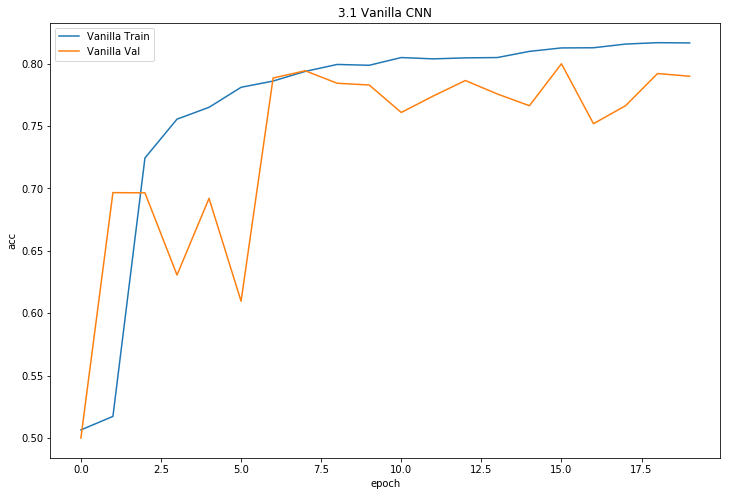

In [0]:
learning_curves({'Vanilla': cnn1}, **{'figsize': (12,8)}, title='3.1 Vanilla CNN')

#### 3.2 Augmented CNN

Augment the data using rotations, mirroring and possibly other transformations. How much can you improve your original model by data augmentation?

In [0]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
datagen = ImageDataGenerator(
        rotation_range=30,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         vertical_flip=True,
        horizontal_flip=True)

I tried a few different data augmentations including image rotation, shifting as well as horizontal and vertical flips.  Because these augmentations increase the size of the dataset significantly, training takes much longer than the model in 3.1.  

The augmentations helped quite a bit when I ran on a very small sample dataset of ~10k elements for training, however as I increased the dataset size the improvement was less pronounced.  Additionally, rotation and flips seemed to improve the model, but shifting actually made it a bit worse. I settled on just using a 30 degree rotation and horizontal flips for the final model as it performed about as well as anything else I found and did not increase compute time as significantly compared to when I included a lot more augmentations.

In [0]:
cnn2 = Sequential()

cnn2.add(Conv2D(32, kernel_size=(3, 3), input_shape=X_train3[0].shape))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(rate=.5))

cnn2.add(Conv2D(64, kernel_size=(3, 3)))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(len(IDC_labels), activation='softmax'))

cnn2.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])

In [0]:
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 22, 22, 64)        256       
__________

In [0]:
cnn2.fit_generator(
    datagen.flow(X_train3, y_train3, batch_size=2000), 
    steps_per_epoch=X_train3.shape[0] / 2000, epochs=20, validation_data=(X_val3, y_val3), verbose=1)

Epoch 1/20
15/15 [==============================] - 18s 1s/step - loss: 1.1659 - acc: 0.6619 - val_loss: 0.5331 - val_acc: 0.7420
Epoch 2/20
15/15 [==============================] - 18s 1s/step - loss: 0.5091 - acc: 0.7634 - val_loss: 0.5202 - val_acc: 0.7572
Epoch 3/20
15/15 [==============================] - 19s 1s/step - loss: 0.4905 - acc: 0.7758 - val_loss: 0.4694 - val_acc: 0.7920
Epoch 4/20
15/15 [==============================] - 17s 1s/step - loss: 0.4655 - acc: 0.7926 - val_loss: 0.4801 - val_acc: 0.7800
Epoch 5/20
15/15 [==============================] - 17s 1s/step - loss: 0.4522 - acc: 0.7976 - val_loss: 0.5277 - val_acc: 0.7476
Epoch 6/20
15/15 [==============================] - 17s 1s/step - loss: 0.4531 - acc: 0.7984 - val_loss: 0.7052 - val_acc: 0.6748
Epoch 7/20
15/15 [==============================] - 18s 1s/step - loss: 0.4379 - acc: 0.8054 - val_loss: 0.7929 - val_acc: 0.6456
Epoch 8/20
15/15 [==============================] - 18s 1s/step - loss: 0.4324 - acc: 0.80

In [0]:
cnn2_score = cnn2.evaluate(X_val3, y_val3, verbose=0)
print(f"""Augmented CNN Validation Loss: {cnn2_score[0]:.3f}""")
print(f"""Augmented CNN Validation Accuracy: {cnn2_score[1]:.3f}""")

Augmented CNN Validation Loss: 0.502
Augmented CNN Validation Accuracy: 0.769


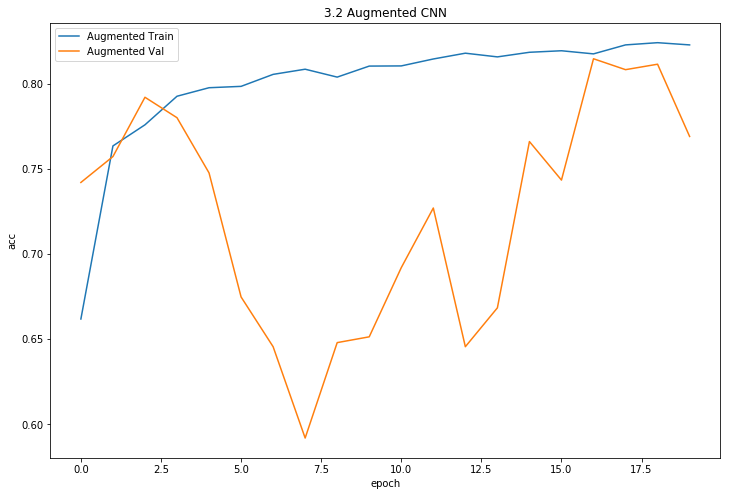

In [0]:
learning_curves({'Augmented': cnn2}, **{'figsize': (12,8)}, title='3.2 Augmented CNN')

One thing I did find peculiar is that the improvement in the validation score was significantly less consistent that the validations scores we observes in Task 2 — simply by looking at the training curves, there is an upward trend, but there are also large dips in the score at different epochs.  For further experimentation it might be useful to try something like Early Stopping, since, for instance if you look at the validation scores, the last three epochs (prior to the vary last) actually achieve above 80% accuracy which was better than the vanilla CNN, but it dropped off a bit at the last epoch on only left us with about 76% validation score.

#### 3.3 ResNet CNN

Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn if you remove the residual connections (i.e. compare a deep model with and without residual connections while the rest of the architecture is constant).

In [0]:
def Unit(x, filters, residuals=True, pool=False):
  """ 
  reference: https://towardsdatascience.com/understanding-residual-networks-9add4b664b03
  """
  
  if residuals:
    res = x

    if pool:
      res = Conv2D(filters=filters, kernel_size=[1,1], strides=(2,2), padding='same')(res)

  out = Conv2D(filters=filters, kernel_size=[3, 3], strides=(1, 1), padding='same')(x)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  
  if pool:
    out = MaxPooling2D(pool_size=(2, 2), padding='same')(out)
      
  out = Conv2D(filters=filters, kernel_size=[3, 3], strides=(1, 1), padding='same')(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  
  if residuals:
    out = Add()([res, out])

  return out

Now I generate a deep ResNet with ~50 layers (each Unit() generates 2 convolutional layers):

In [0]:
resnet_inputs = Input(shape=X_train3[0].shape)

net = Conv2D(filters=32, kernel_size=[3, 3], strides=(1, 1), padding='same')(resnet_inputs)
 
# 12 layers
for i in range(3):
  net = Unit(net, 32, pool=True)
  net = Unit(net, 32)

# 12 layers
for i in range(3):
  net = Unit(net,64, pool=True)
  net = Unit(net,64)

# 12 layers
for i in range(3):
  net = Unit(net,128, pool=True)
  net = Unit(net,128)

# 12 layers
for i in range(3):
  net = Unit(net, 256, pool=True)
  net = Unit(net, 256)

net = BatchNormalization()(net)
net = Activation('relu')(net)

net = Flatten()(net)
net = Dense(units=len(IDC_labels), activation="softmax")(net)

cnn3 = Model(inputs=resnet_inputs, outputs=net)

cnn3.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
cnn3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 50, 50, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 50, 50, 32)   9248        conv2d_134[0][0]                 
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 50, 50, 32)   128         conv2d_136[0][0]                 
__________________________________________________________________________________________________
activation

Now I try the same model but without residual connections:

In [0]:
no_res_inputs = Input(shape=X_train3[0].shape)

net = Conv2D(filters=32, kernel_size=[3, 3], strides=(1, 1), padding='same')(no_res_inputs)
 
# 12 layers
for i in range(3):
  net = Unit(net, 32, residuals=False, pool=True)
  net = Unit(net, 32, residuals=False)

# 12 layers
for i in range(3):
  net = Unit(net,64, residuals=False, pool=True)
  net = Unit(net,64, residuals=False)

# 12 layers
for i in range(3):
  net = Unit(net,128, residuals=False, pool=True)
  net = Unit(net,128, residuals=False)

# 12 layers
for i in range(3):
  net = Unit(net, 256, residuals=False, pool=True)
  net = Unit(net, 256, residuals=False)

net = BatchNormalization()(net)
net = Activation('relu')(net)

net = Flatten()(net)
net = Dense(units=len(IDC_labels), activation="softmax")(net)

cnn4 = Model(inputs=no_res_inputs, outputs=net)

cnn4.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
cnn4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_771 (Conv2D)          (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_772 (Conv2D)          (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_682 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
activation_684 (Activation)  (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_773 (Conv2D)          (None, 25, 25, 32)        9248      
__________

Now model training:

In [0]:
cnn3.fit(X_train3, y_train3, batch_size=4000, epochs=20, validation_data=(X_val3, y_val3), verbose=1)

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 25s 843us/step - loss: 0.6436 - acc: 0.6674 - val_loss: 0.5732 - val_acc: 0.7134
Epoch 2/20
30000/30000 [==============================] - 11s 367us/step - loss: 0.5281 - acc: 0.7547 - val_loss: 0.7040 - val_acc: 0.6656
Epoch 3/20
30000/30000 [==============================] - 11s 369us/step - loss: 0.5070 - acc: 0.7674 - val_loss: 0.5892 - val_acc: 0.7164
Epoch 4/20
30000/30000 [==============================] - 11s 368us/step - loss: 0.4919 - acc: 0.7751 - val_loss: 1.1338 - val_acc: 0.5714
Epoch 5/20
30000/30000 [==============================] - 11s 364us/step - loss: 0.4839 - acc: 0.7798 - val_loss: 0.5382 - val_acc: 0.7452
Epoch 6/20
30000/30000 [==============================] - 11s 361us/step - loss: 0.4713 - acc: 0.7848 - val_loss: 0.6496 - val_acc: 0.6928
Epoch 7/20
30000/30000 [==============================] - 11s 361us/step - loss: 0.4629 - acc: 0.7903 - val_loss: 1.2

In [0]:
cnn4.fit(X_train3, y_train3, batch_size=4000, epochs=20, validation_data=(X_val3, y_val3), verbose=1)

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 61s 2ms/step - loss: 0.7635 - acc: 0.5600 - val_loss: 8.0664 - val_acc: 0.4966
Epoch 2/20
30000/30000 [==============================] - 10s 330us/step - loss: 0.6697 - acc: 0.6289 - val_loss: 6.0616 - val_acc: 0.5078
Epoch 3/20
30000/30000 [==============================] - 10s 329us/step - loss: 0.6543 - acc: 0.6489 - val_loss: 1.7126 - val_acc: 0.7050
Epoch 4/20
30000/30000 [==============================] - 10s 327us/step - loss: 0.6042 - acc: 0.6969 - val_loss: 1.3774 - val_acc: 0.6920
Epoch 5/20
30000/30000 [==============================] - 10s 325us/step - loss: 0.6008 - acc: 0.6942 - val_loss: 1.4195 - val_acc: 0.4982
Epoch 6/20
30000/30000 [==============================] - 10s 324us/step - loss: 0.5768 - acc: 0.7269 - val_loss: 1.0515 - val_acc: 0.4966
Epoch 7/20
30000/30000 [==============================] - 10s 323us/step - loss: 0.5419 - acc: 0.7434 - val_loss: 1.068

Let's compare the results with and without ResNet:

In [0]:
cnn3_score = cnn3.evaluate(X_val3, y_val3, verbose=0)
print(f"""ResNet Validation Loss: {cnn3_score[0]:.3f}""")
print(f"""ResNet Validation Accuracy: {cnn3_score[1]:.3f}""")

ResNet Validation Loss: 0.648
ResNet Validation Accuracy: 0.659


In [0]:
cnn4_score = cnn4.evaluate(X_val3, y_val3, verbose=0)
print(f"""Without ResNet Validation Loss: {cnn4_score[0]:.3f}""")
print(f"""Without ResNet Validation Accuracy: {cnn4_score[1]:.3f}""")

Without ResNet Validation Loss: 0.790
Without ResNet Validation Accuracy: 0.497


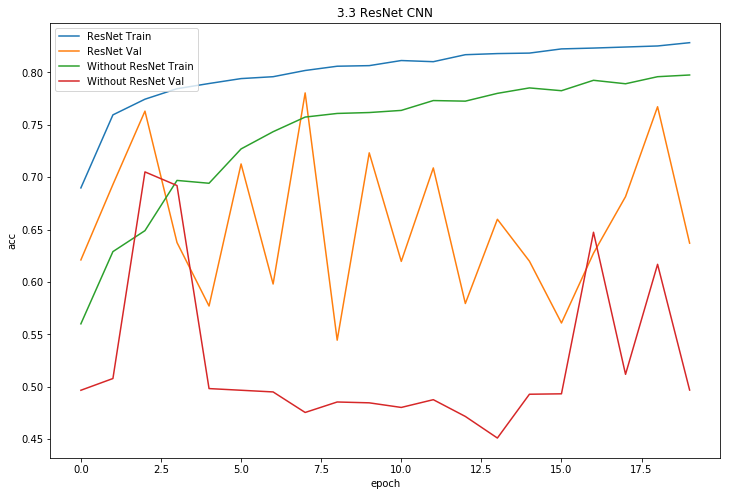

In [0]:
resnet = {
    'ResNet': cnn3,
    'Without ResNet': cnn4
}

learning_curves(resnet, **{'figsize': (12,8)}, title='3.3 ResNet CNN')

Clearly when I remove the residual connections the model does not learn—the validation accuracy with residual connection doesn't achieve better than a random guess, whereas with residual connection the model performs much better.

Interestingly, when I used a small dataset of ~10k this was even more pronounced, and the training accuracy also didn't improve much beyond a random guess.  What I have inferred from running these CNN models is that having a large enough dataset size has a big impact on performance.

I also saw the problem with the ResNet that the validation score improvement was inconsistent, despite that it was in fact improving over time.  Early stopping might help here also.  One other possiblity is that because there are so many more layers, we need a lot more epochs to thoroughly train the model.

#### Learning Curves - Training and Validation

Now like in Task 2 I plot the learning curves:

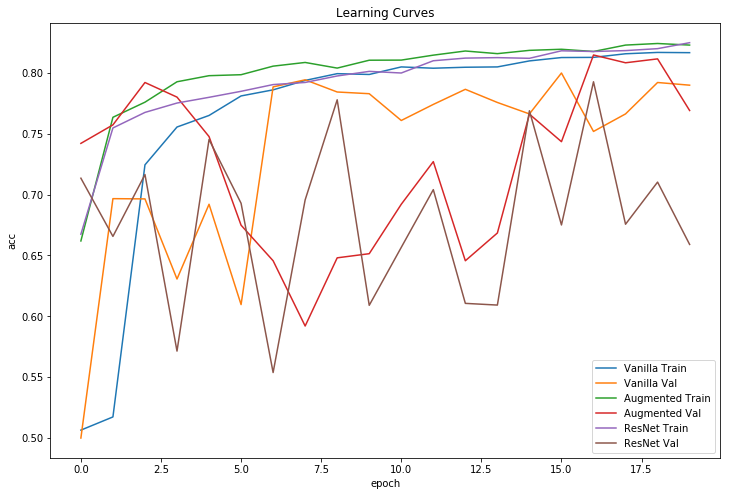

In [0]:
models = {
    'Vanilla': cnn1,
    'Augmented': cnn2,
    'ResNet': cnn3
}

learning_curves(models, **{'figsize': (12,8)})

#### Generalization

In [0]:
cnn1_gen = cnn1.evaluate(X_test3, y_test3, verbose=0)
print(f"""Vanilla CNN Test Loss: {cnn1_gen[0]:.3f}""")
print(f"""Vanilla CNN Test Accuracy: {cnn1_gen[1]:.3f}""")

Vanilla CNN Test Loss: 0.439
Vanilla CNN Test Accuracy: 0.797


In [0]:
cnn2_gen = cnn2.evaluate(X_test3, y_test3, verbose=0)
print(f"""Augmented CNN Test Loss: {cnn2_gen[0]:.3f}""")
print(f"""Augmented CNN Test Accuracy: {cnn2_gen[1]:.3f}""")

Augmented CNN Test Loss: 0.483
Augmented CNN Test Accuracy: 0.779


In [0]:
cnn3_gen = cnn3.evaluate(X_test3, y_test3, verbose=0)
print(f"""ResNet CNN Test Loss: {cnn3_gen[0]:.3f}""")
print(f"""ResNet CNN Test Accuracy: {cnn3_gen[1]:.3f}""")

ResNet CNN Test Loss: 0.629
ResNet CNN Test Accuracy: 0.677


Depsire that the Augmented CNN did achieve the highest validation scores at certain epochs, it dropped on the final epoch and does not outperform the Vanilla CNN on the test set.  Also, the ResNet was not able to achieve a higher score than the Vanilla CNN or Augmented CNN, possibly because it requires more epochs/ compute time to thoroughly train such a deep model.